In [104]:
import pandas as pd
import json
import requests
import warnings
from matplotlib import pyplot as plt
import matplotlib
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
%matplotlib inline
from IPython.display import IFrame
import re
import numpy

font = {'family' : 'helvetica',
        'size'   : 24}

matplotlib.rc('font', **font)

# Cuomo Campaign Contributions from Board of Elections

I read the CSV, then I take the dollar signs out of the 'Amount' column, ...and convert it to float so I can do calculations.

I convert the 'Date' column to Pandas datetime, so I can sort and filter by date.

In [105]:
df = pd.read_csv("Campaign_Contributions.csv")
df = df[['Donor','Address', 'Check No.', 'Amount', 'Date','Recipient','Transaction Code', 'Contribution Code', 'Fiscal Report']]
ftm_df = pd.read_csv("FollowTheMoneyDownload20180705(010706).csv")
#Since Follow the Money is out of date anyway, I'm actually just interested in unique donors over the years.
#This will help me identify Cuomo donors, because so many of them have been his donors for a long time.
ftm_df = ftm_df.drop_duplicates('Original_Name', keep='first')

In [106]:
df['Amount'] = df['Amount'].replace( '[\$,)]','', regex=True ).astype(float)
df['Donor'] = df['Donor'].str.strip()
ftm_df['Original_Name'] = ftm_df['Original_Name'].str.strip() 
new_df = pd.merge(df, ftm_df, left_on='Donor', right_on='Original_Name', how='left', suffixes=['_boe','_ftm'])

## FollowTheMoney has data on individual donors, but they aggregate donations.

So I am going to use their data, combined with Board of Elections donations

In [107]:
new_df['Date'] = pd.to_datetime(new_df['Date_boe'], infer_datetime_format=True)
new_df['Donation_Date']=new_df['Date']
new_df.set_index('Date', inplace=True)
new_df.sort_index(axis=0, inplace=True)
new_df.dropna(subset=['Date_boe'], inplace=True)

In [108]:
new_df = new_df[['Donor', 'Address', 'Check No.', 'Amount_boe', 'Date_boe',
       'Recipient', 'Transaction Code', 'Contribution Code',
       'Fiscal Report',
       'Filing_Jurisdiction', 'Filer',
       'Candidate',
       'Candidate_Entity',
       'Election_Status',
       'Status_of_Candidate',
       'Election_Jurisdiction',
       'Election_Year',
       'Election_Type',
       'Original_Name',
       'Contributor',
       'Type_of_Contributor','Specific_Business', 'General_Industry','Broad_Sector',
       'City','State','Zip', 'In-State',
       'Parent_Org_or_Employer']]

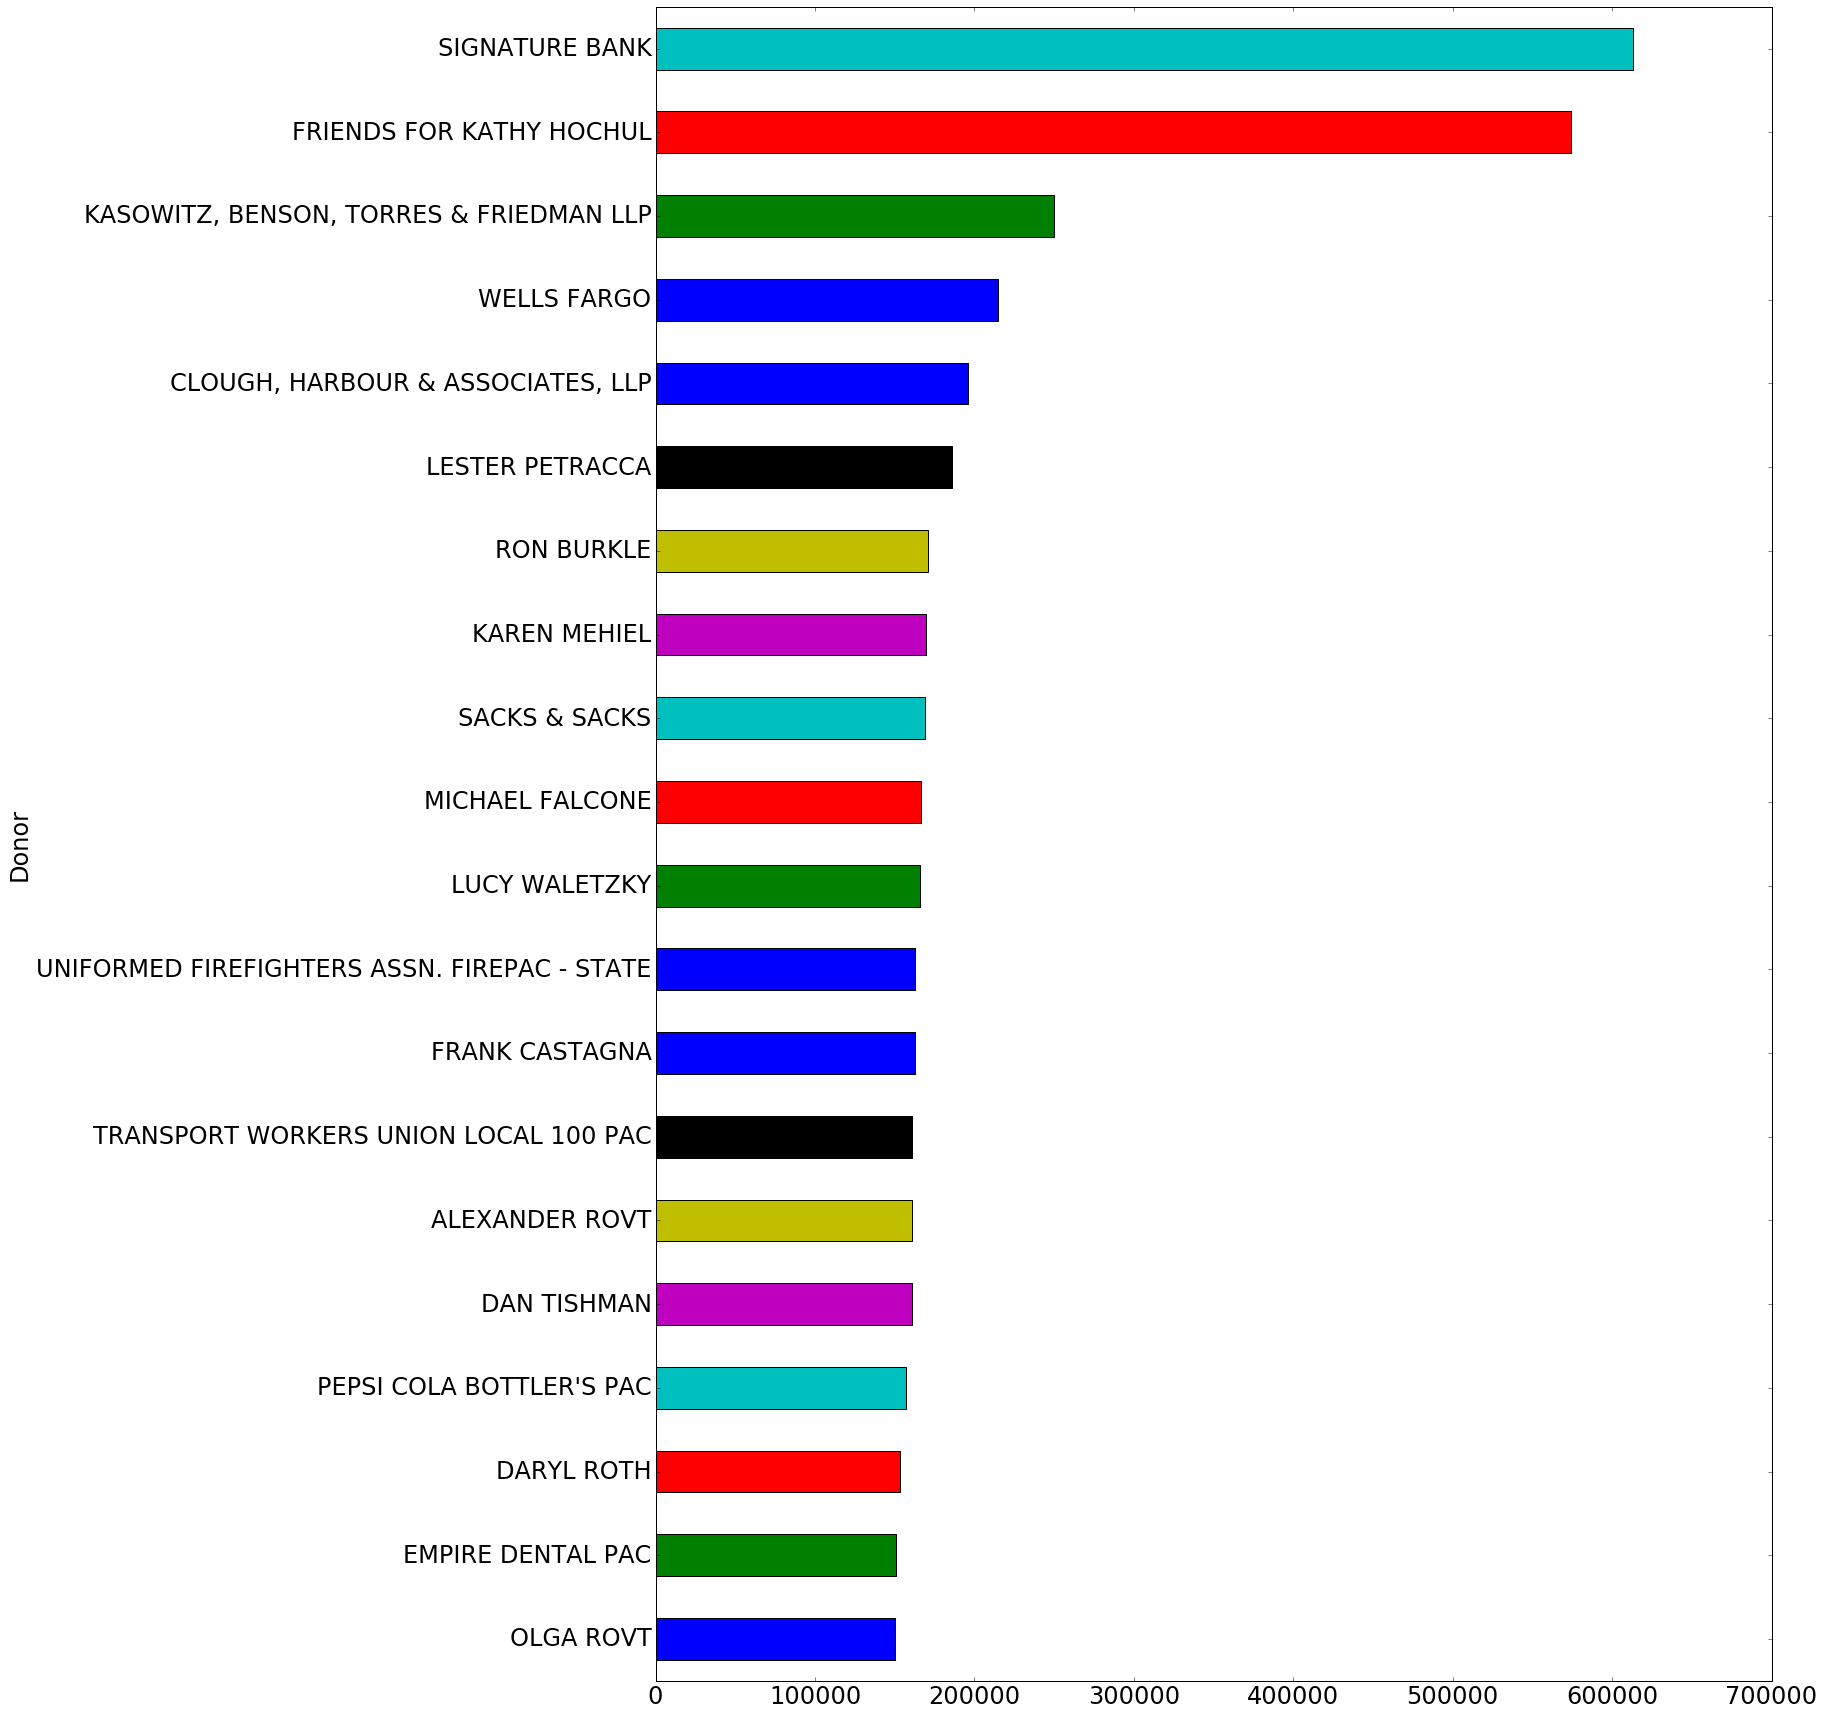

In [109]:
plt.figure(figsize=(20,30))
new_df['2010-01-01':].groupby('Donor').filter(lambda x: x['Amount_boe'].sum()>150000)\
.groupby('Donor')['Amount_boe'].sum().sort_values().plot(kind='barh')

## Notable donors include:
*Signature bank*
- Ivanka Trump is on the board of directors
- Barney Frank is on the board of directors
- Ron Wasserman is an "associate group director", and is a member of AIPAC and chairman of Fuel for Truth, an anti-muslim think tank-funded org

*Kathy Hochul*
- Lieutenant governor of NYS
- "Friends for Kathy Hochul" receives money from LLC's, donates to Cuomo
- Kathy Hochul is heavily invested in the oil industry

*Kasowitz Benson Torres Friedman LLP*
- major RNC donor ($251,900)
- Trump donor
- https://projects.propublica.org/trump-town/organizations/kasowitz-benson-torres-friedman-llp !!!

In [110]:
IFrame('https://littlesis.org/maps/2780-kathy-hochul-s-fossil-fuel-investments/embedded/v2', width=700, height=350, scrolling='no')

## "Governor Glenwood" indeed!

In [111]:
print("Over the years, Glenwood has given", new_df[new_df['Parent_Org_or_Employer'].str.contains("GLENWOOD", na=False)]['Amount_boe'].sum(), "to Cuomo's campaign.")

Over the years, Glenwood has given 889400.0 to Cuomo's campaign.


In [112]:
#EDIT: John and Peter want to look at everything just from 2010 onward.
df_warchest = new_df['2010-01-01':]
df_warchest['Donor'] = df_warchest['Donor'].str.strip()

In [134]:
#These are some entities that I know are Real Estate donors: Fisher Brothers, and Brookfield Properties, NORSTAR.
#May 18, 2017, Cuomo announces renewal of 421a. One day later, May 19, 2017, he receives 159,000
#I see that Brookfield donated 40,000 on January 9, 2017, and another 150,000 this year on the same date.
#What has Cuomo done to help Brookfield?
#Cablevision has given to Cuomo under many, many different names. I got this list from the SEC.

df_warchest.loc[df_warchest['Donor'].str.contains("FISHER BROTHERS", na=False), 'General_Industry']='Real Estate'
df_warchest.loc[df_warchest['Donor'].str.contains("FISHER BROTHERS", na=False), 'Parent_Org_or_Employer']='Fisher Brothers'
df_warchest.loc[df_warchest['Address']=='FL 42 299 PARK AVE NEW YORK, NY, 10171', 'General_Industry']='Real Estate'
df_warchest.loc[df_warchest['Address']=='FL 42 299 PARK AVE NEW YORK, NY, 10171', 'Parent_Org_or_Employer']='Fisher Brothers'

df_warchest.loc[df_warchest['Donor'].str.contains("BOP", na=False), 'General_Industry']='Miscellaneous Finance, Insurance & Real Estate'
df_warchest.loc[df_warchest['Donor'].str.contains("BOP", na=False), 'Parent_Org_or_Employer']='Brookfield'

df_warchest.loc[df_warchest['Donor'].str.contains("CLOUGH, HARBOUR", na=False), 'Parent_Org_or_Employer']='Longpoint Capital'
df_warchest.loc[df_warchest['Donor'].str.contains("CLOUGH, HARBOUR", na=False), 'General_Industry']='Miscellaneous Finance, Insurance & Real Estate'

df_warchest.loc[((df_warchest['General_Industry'] == 'Uncoded') & (df_warchest['Donor'].str.contains("NORSTAR"))), 'General_Industry']='Real Estate'

df_warchest.loc[df_warchest['Donor'].str.contains("REXSCOTT", na=False), 'Parent_Org_or_Employer']='RXR Realty'
df_warchest.loc[((df_warchest['General_Industry'] == 'Uncoded') & (df_warchest['Donor'].str.contains("REXSCOTT"))), 'General_Industry']='Real Estate'
df_warchest.loc[df_warchest['Donor'].str.contains("RXR", na=False), 'Parent_Org_or_Employer']='RXR Realty'

df_warchest.loc[df_warchest['Donor'].str.contains(r"\bSTV\b", na=False), 'Parent_Org_or_Employer']='STV Incorporated'
df_warchest.loc[df_warchest['Donor']=="STV", 'General_Industry']='Construction Services'
df_warchest.loc[df_warchest['Donor']=="STV", 'Parent_Org_or_Employer']='STV Incorporated'

df_warchest.loc[df_warchest['Address']=='205 W WELSH DR DOUGLASSVILLE, PA, 19518', 'Parent_Org_or_Employer'] = 'STV Incorporated'
df_warchest.loc[df_warchest['Address']=='205 W WELSH DR DOUGLASSVILLE, PA, 19518', 'General_Industry']='Construction Services'

df_warchest.loc[df_warchest['Address']=='1300 CLINTON SQ ROCHESTER, NY, 14604', 'Parent_Org_or_Employer']='Nixon Peabody LLP'
df_warchest.loc[df_warchest['Address']=='1300 CLINTON SQ ROCHESTER, NY, 14604', 'General_Industry']='Lawyers & Lobbyists'

#List of subsidiaries of Cablevision, from: https://www.sec.gov/Archives/edgar/data/784681/000162828016011667/cvc-12312015xex21.htm
cablevision_list = ["1015 TIFFANY STREET", "1047 E 46TH STREET", "111 NEW SOUTH ROAD", "1111 STEWART",
"1144 ROUTE 109 CORP.", "151 S. FULTON STREET", "2234 FULTON STREET", "389 ADAMS STREET", "4CONNECTIONS",
"A-R CABLE SERVICES - NY", "BBHI HOLDINGS", "CCG HOLDINGS", "Clearview Cinemas", "CORAM ROUTE 112",
"CSC ACQUISITION - MA", "CSC ACQUISITION - NY", "CSC ACQUISITION", "CSC GATEWAY", "CSC INVESTMENTS",
"CSC MVDDS", "CSC NASSAU II", "CSC OPTIMUM HOLDINGS", "CSC T HOLDINGS I", "CSC T HOLDINGS II",
"CSC T HOLDINGS III", "CSC T HOLDINGS IV", "CSC TECHNOLOGY", "CSC TKR",
"CSC TRANSPORT II", "CSC TRANSPORT III", "CSC TRANSPORT", "CSC VT", "DTV NORWICH",
"Clearband", "FROWEIN ROAD", "LIGHTPATH VOIP", "MSG VARSITY NETWORK", "MSG Varsity Network",
"MSGVN", "N12N", "NEWS 12 COMPANY", "News 12", "NEWSDAY", "NMG HOLDINGS", "NY OV LLC", "PETRA CABLEVISION CORP.",
"PRINCETON VIDEO IMAGE ISRAEL", "PVI HOLDINGS", "PVI PHILIPPINES", "PVI VIRTUAL MEDIA SERVICES",
"RAINBOW MVDDS COMPANY", "RASCO HOLDINGS", "RMVDDS", "OMGFAST!", "SAMSON CABLEVISION CORP.",
"SUFFOLK CABLE", "TELERAMA", "THE NEW YORK INTERCONNECT", "TRISTATE DIGITAL GROUP", "WIFI CT-NJ", "WIFI NY"]
#https://www.sec.gov/Archives/edgar/data/784681/000162828016011667/cvc-12312015xex21.htm
for shell in cablevision_list:    
    df_warchest.loc[df_warchest['Donor'].str.contains(shell, re.IGNORECASE, na=False), 'Parent_Org_or_Employer']='Cablevision Systems'
    df_warchest.loc[df_warchest['Donor'].str.contains(shell, re.IGNORECASE, na=False), 'General_Industry']='Cable TV'
    
df_warchest.loc[df_warchest['Donor'] == 'NY OV LLC', 'Parent_Org_or_Employer']='Cablevision Systems'
df_warchest.loc[df_warchest['Donor'] == 'NY OV LLC', 'General_Industry']='Cable TV'


#Anthony Bacchi, founder of Teli Stat, recipient of 5 million NY state grant, also CEO of Restorative Continuum, LLC
df_warchest.loc[df_warchest['Donor']=='RESTORATIVE CONTINUUM LLC', 'General_Industry']='Health Services'
df_warchest.loc[df_warchest['Donor']=='RESTORATIVE CONTINUUM LLC', 'Parent_Org_or_Employer']='Teli Stat'

df_warchest.loc[df_warchest['Address']== '30-56 WHITESTONE EXPRESSWAY WHITESTONE, NY, 11354', 'General_Industry']='Real Estate'
df_warchest.loc[df_warchest['Address']== '30-56 WHITESTONE EXPRESSWAY WHITESTONE, NY, 11354', 'Parent_Org_or_Employer']='Triangle Equities'

df_warchest.loc[df_warchest['Address']== 'STE 100 438 FIFTH AVE PELHAM, NY, 10803', 'General_Industry']='General Contractors'
df_warchest.loc[df_warchest['Address']== 'STE 100 438 FIFTH AVE PELHAM, NY, 10803', 'Parent_Org_or_Employer']='Macquesten Development'
df_warchest.loc[df_warchest['Address']== '438 FIFTH AVE PELHAM, NY, 10803', 'General_Industry']='General Contractors'
df_warchest.loc[df_warchest['Address']== '438 FIFTH AVE PELHAM, NY, 10803', 'Parent_Org_or_Employer']='Macquesten Development'
df_warchest.loc[df_warchest['Donor']== 'RELLA FOGLIANO', 'General_Industry']='General Contractors'
df_warchest.loc[df_warchest['Donor']== 'RELLA FOGLIANO', 'Parent_Org_or_Employer']='Macquesten Development'
df_warchest.loc[df_warchest['Donor']== 'JOSEPH BREDA', 'General_Industry']='General Contractors'
df_warchest.loc[df_warchest['Donor']== 'JOSEPH BREDA', 'Parent_Org_or_Employer']='Macquesten Development'


In [141]:
rec_df=df_warchest['2017-01-01':]
rec_df[rec_df['General_Industry'] == 'Uncoded'].groupby('Date_boe')['Amount_boe'].sum().sort_values(ascending=False)
rec_df[(rec_df['Date_boe']=='12/15/2017')&(rec_df['General_Industry'] == 'Uncoded')].sort_values(by='Amount_boe', ascending=False)
#rec_df[rec_df['Donor'].str.contains("TRIAN", na=False)]

111000.0

## Project Compassion NY LLC
- gave a one-time contribution of $50,000 on 12/13/2017
- Is based in California?? No idea what the connection is and probably not something we should pursue. Small fish!

## Restorative Continuum LLC
- CEO is Anthony Bachi, also the founder of Telistat, which is received a 5 million grant in 2016, and in August 2017 a Long Island facility got a 1.5 million grant to implement a Telistat Restorative Care Unit.
- https://www.prnewswire.com/news-releases/telistat-introduces-innovative-healthcare-unit-to-long-island-300501207.html

## RXR, REXSCOTT, GABELI... Various LLCs
- Gabeli and REXSCOTT each gave 65000 on the same date (05/19/2017). Gabeli may be the same as "The Gabeli Private Equity Fund"
- REXSCOTT, Gabeli, RXR all have the same address: '625 RXR PLZ UNIONDALE, NY, 11556'.
- I'm not sure if they are the same, related, renting the same space, etc. but RXR is a big Cuomo donor and was also covered by the Intercept recently:
- https://theintercept.com/2018/07/12/andrew-cuomo-donations-ice/

## Triangle Equities
- Real Deal reported they gave 50,000, but they actually gave 75,000 total in 2017 (and have been a big donor since 2011, when they gave 25,000) if you count all of the LLCs that used the same Whitestone, NY address: 30-56 WHITESTONE EXPRESSWAY WHITESTONE, NY, 11354
- 496 WEST JERICHO TURNPIKE LLC, TRIANGLE EQUITIES JUNCTION LLC, 755 CO-OP CITY LLC
- Their big "Lighthouse Point" project was delayed in the senate: https://therealdeal.com/2015/12/18/state-senate-delays-funding-for-lighthouse-point-project/

## Macquesten Development LLC
- Donated 40,000 in 4 separate donations on 5/18/2017 and 12/15/2017
- 3 different LLCs, all from the same address: STE 100 438 FIFTH AVE PELHAM, NY, 10803	
- Also their principals are big donors (and named as donors):

    - Rella Fogliano – President, 111000 total given to Cuomo as of January 2018
    - Joseph Breda – Principal/Special Projects Manager, 85,000 total given to Cuomo as of January 2018

In [143]:
print("Joseph Breda has given: ", df_warchest[df_warchest['Donor']=='JOSEPH BREDA']['Amount_boe'].sum())
print("Rella Fogliano has given: ", df_warchest[df_warchest['Donor']=='RELLA FOGLIANO']['Amount_boe'].sum())

Joseph Breda has given:  85000.0
Rella Fogliano has given:  111000.0


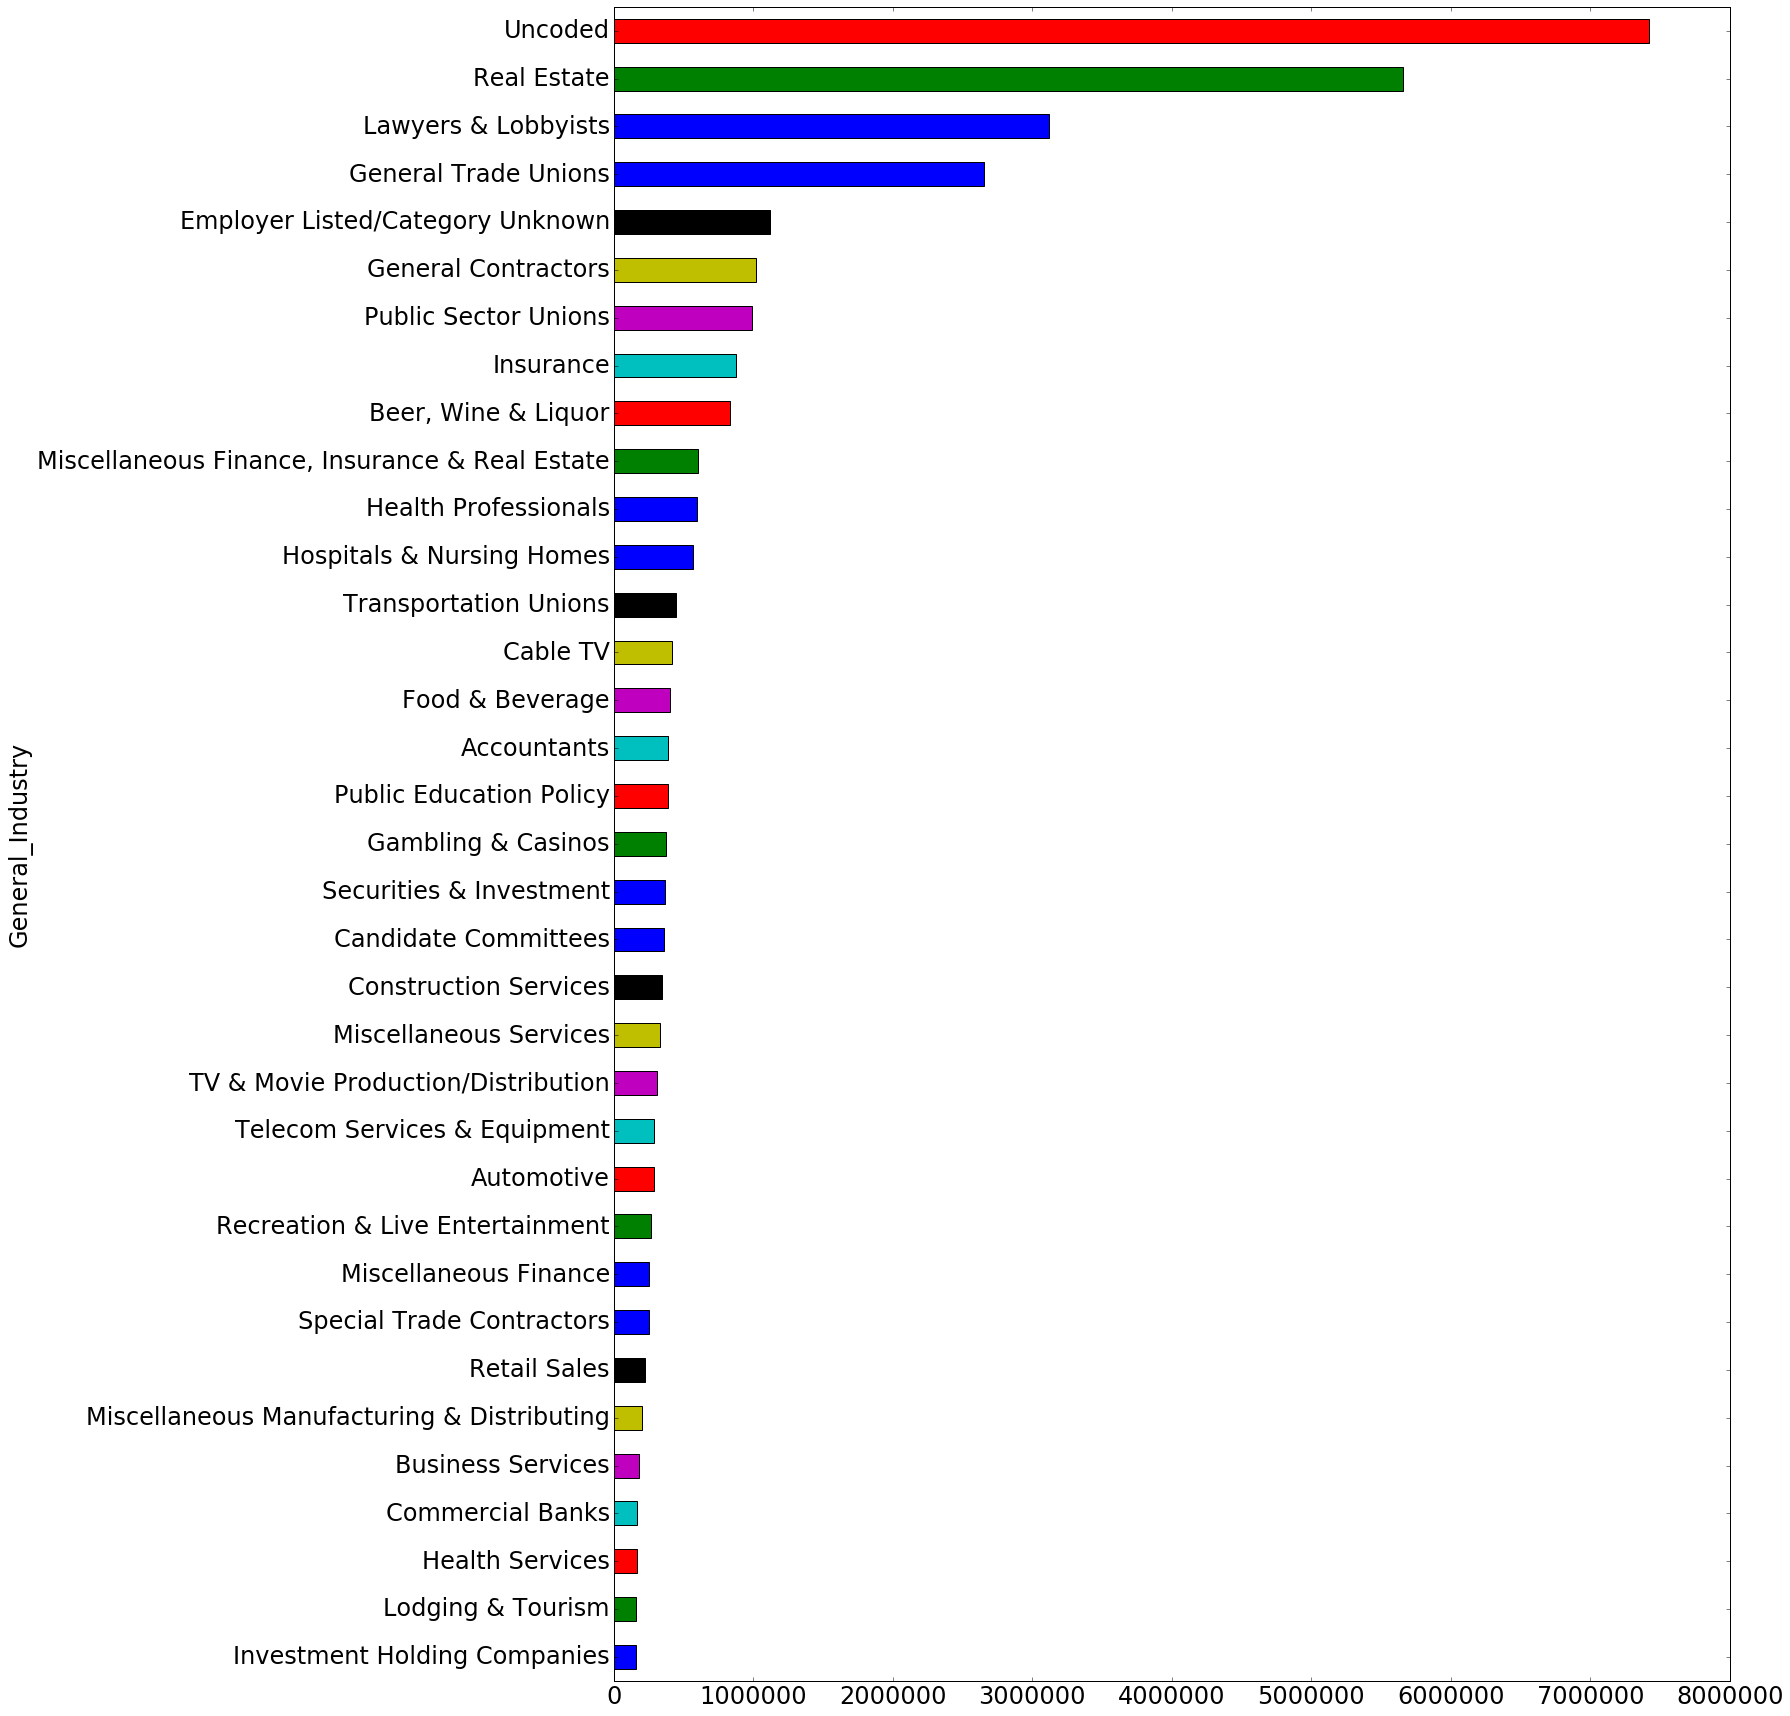

In [144]:
plt.figure(figsize=(20,30))
df_warchest.groupby('General_Industry').filter(lambda x: x['Amount_boe'].sum() > 150000)\
.groupby('General_Industry')['Amount_boe']\
.sum().sort_values()\
.plot(y='Amount_boe', x='General_Industry', kind='barh')

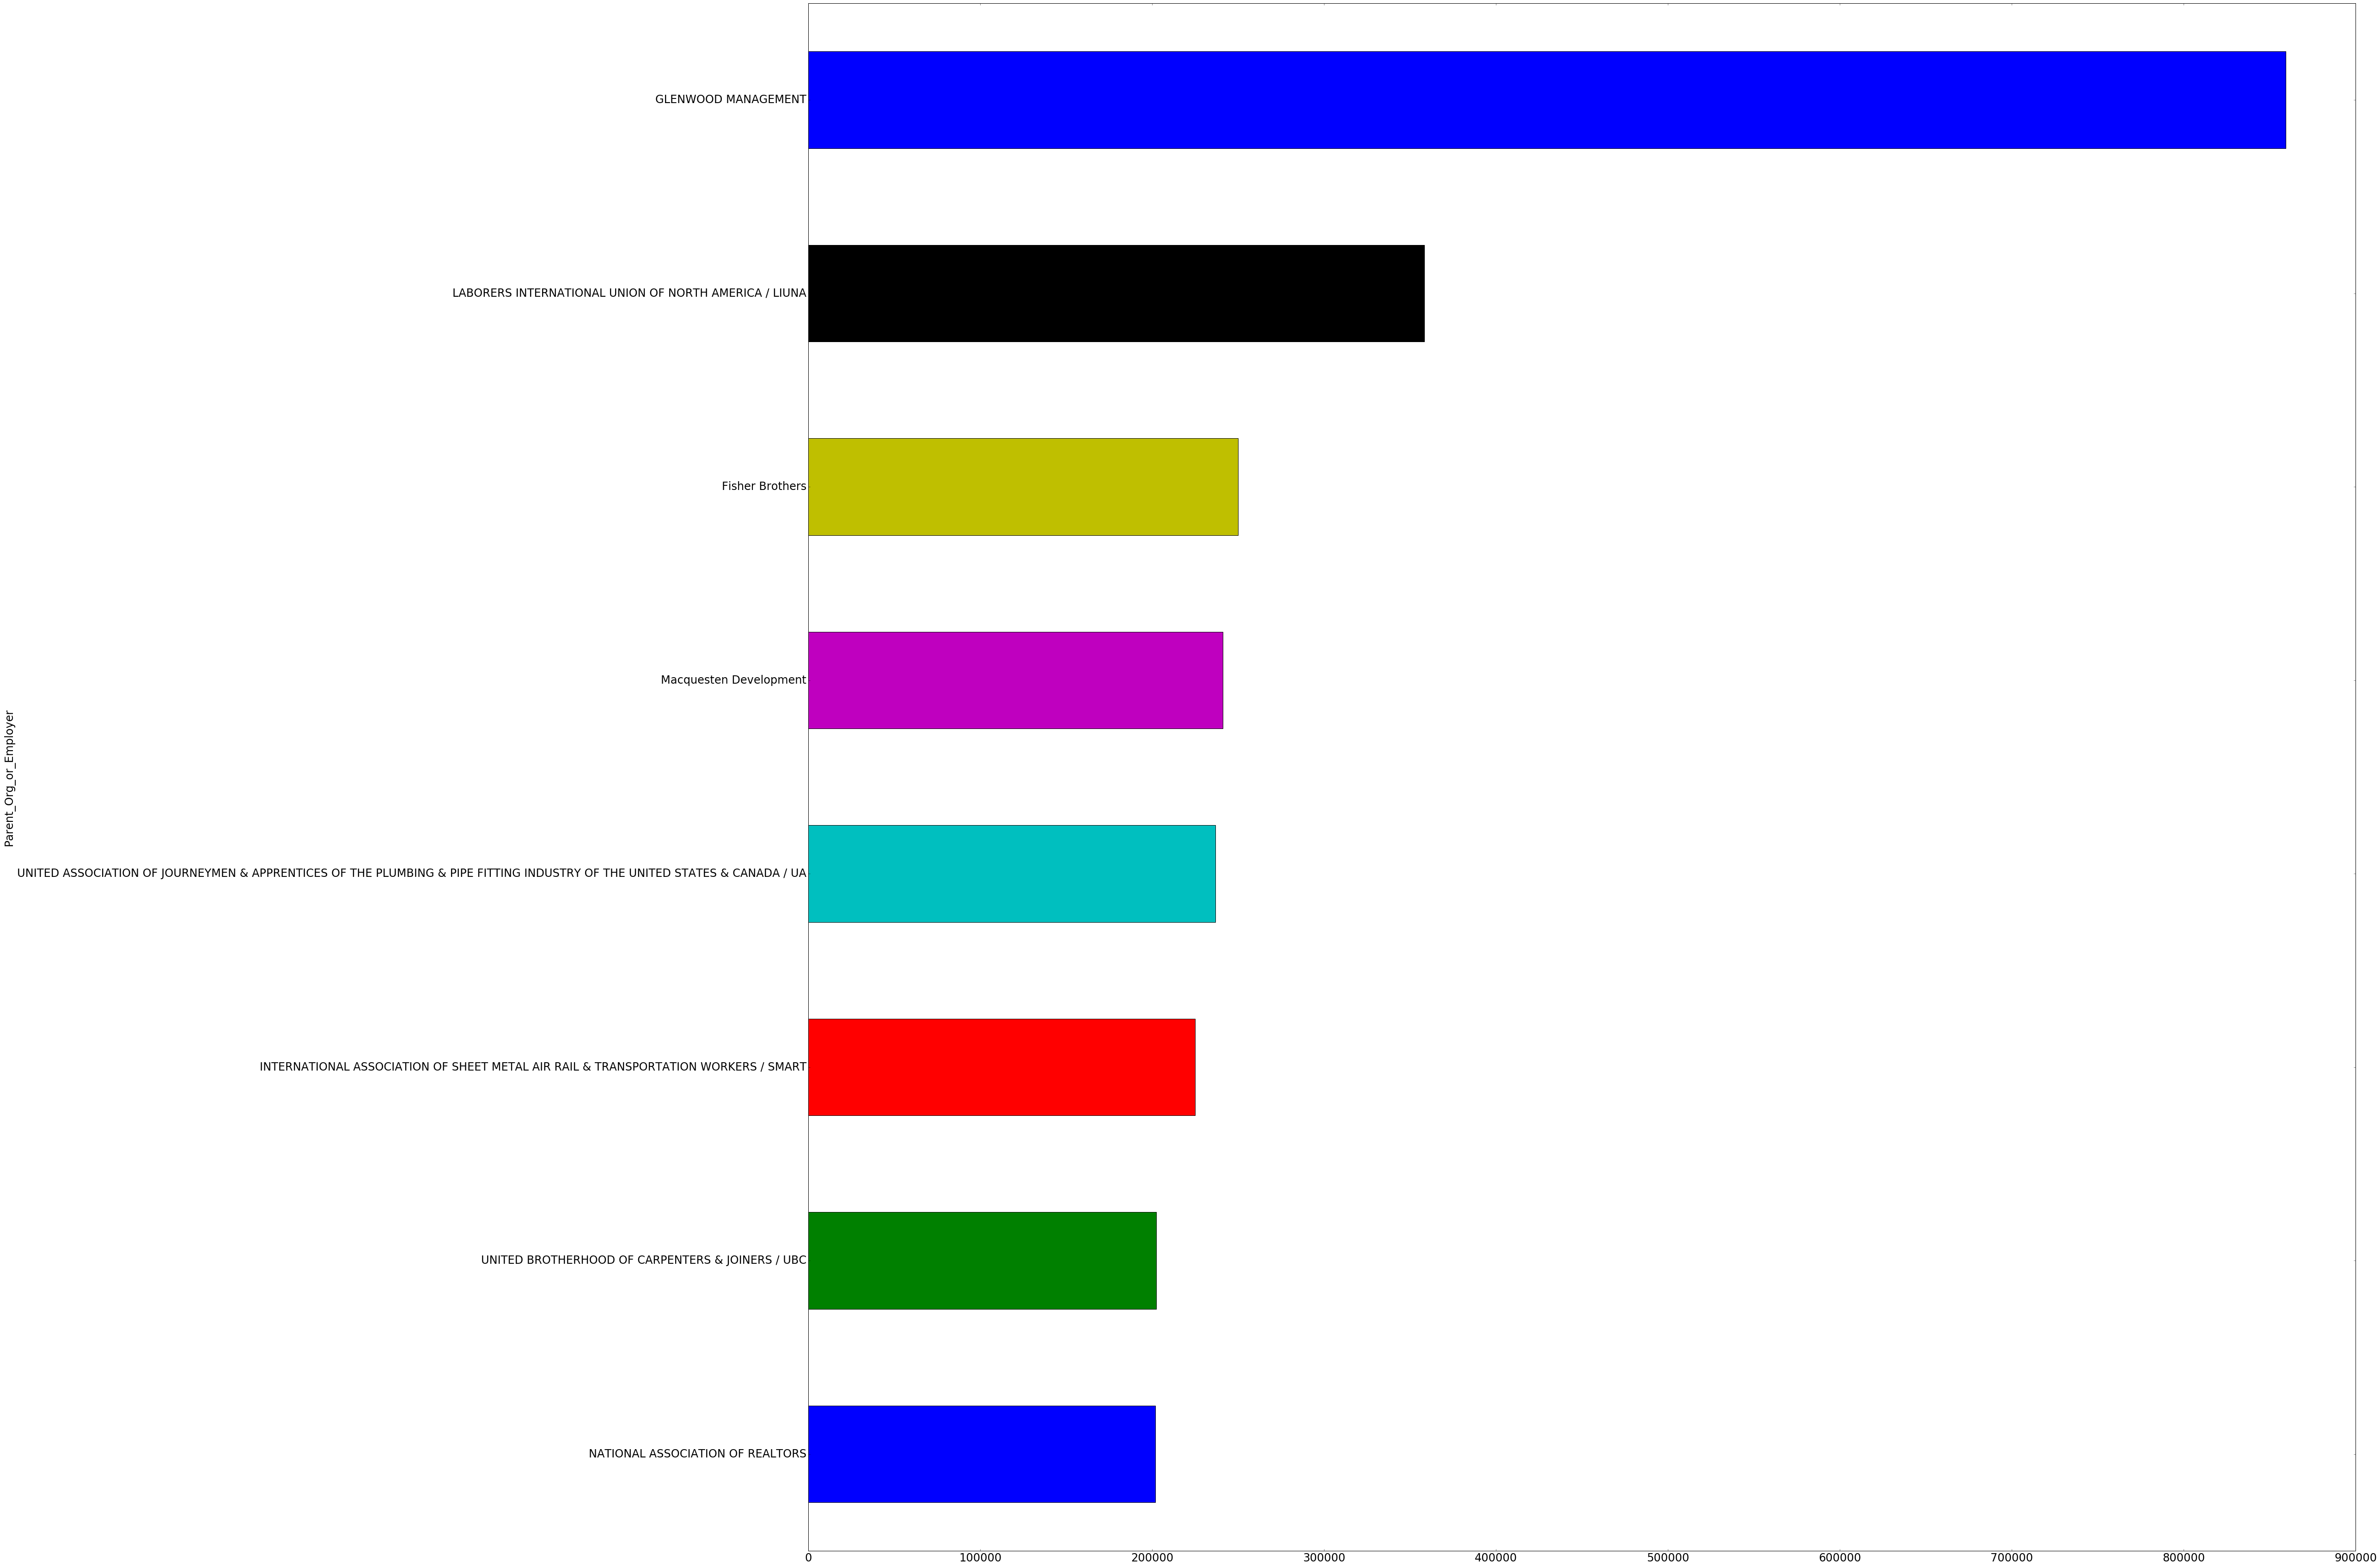

In [150]:
plt.figure(figsize=(60,60))
df_warchest.groupby('Parent_Org_or_Employer').filter(lambda x: x['Amount_boe'].sum() > 200000)\
.groupby('Parent_Org_or_Employer')['Amount_boe']\
.sum().sort_values()\
.plot(y='Amount_boe', x='Parent_Org_or_Employer', kind='barh')

In [ ]:
df_warchest.groupby('Address')['Donor'].nunique().sort_values(ascending=False)

## Nixon Peabody, LLP is an interesting case.

They've given a total of 51,326 to Cuomo-- but their average donation is $250. Their employees give to Cuomo all on the same day(s)

In [ ]:
print("\nTotal from Nixon Peabody: ", df_warchest[df_warchest['Parent_Org_or_Employer']=='Nixon Peabody LLP']['Amount_boe'].sum())
print("Average from Nixon Peabody: " ,df_warchest[df_warchest['Parent_Org_or_Employer']=='Nixon Peabody LLP']['Amount_boe'].median())
print("\nDates Nixon Peabody gave to Cuomo:\n")

values = df_warchest[df_warchest['Address']=='1300 CLINTON SQ ROCHESTER, NY, 14604']['Date_boe'].value_counts().keys().tolist()
counts = df_warchest[df_warchest['Address']=='1300 CLINTON SQ ROCHESTER, NY, 14604']['Date_boe'].value_counts().tolist()

i=0

for value in values:
    print("On", value, "there were", counts[i], "donations.")
    i+=1

## The data from Follow the Money is rich, but incomplete:
With their data, I didn't have information on 85% of Cuomo's donors. Now it is a bit clearer.

In [ ]:
count, _ = df_warchest.shape

print("Percent of 'Broad Sector' unknown:", str(round(df_warchest[(df_warchest['Broad_Sector']== 'Unknown') | (df_warchest['Broad_Sector']== 'Uncoded')]\
['Donor'].count()/count, 2)*100)+"%")
print("Percent of 'General Industry' unknown:", str(round(df_warchest[(df_warchest['General_Industry']== 'Unknown') | (df_warchest['General_Industry']== 'Uncoded')]\
['Donor'].count()/count, 2)*100)+"%")
print("Percent of 'Parent Org or Employer' unknown:", str(round(df_warchest[(df_warchest['Parent_Org_or_Employer']== 'Unknown') | (df_warchest['Parent_Org_or_Employer']== 'Uncoded')]\
['Donor'].count()/count, 2)*100)+ "%")
print("Percent of 'specific business' unknown:", str(round(df_warchest[(df_warchest['Specific_Business']== 'Unknown') | (df_warchest['Specific_Business']== 'Uncoded')]\
['Donor'].count()/count, 2)*100)+"%")

## LLC's

In [ ]:
unknown_llc_number = df_warchest[(df_warchest['Donor'].str.contains('LLC'))|\
            (df_warchest['Broad_Sector']=='Unknown')|\
            (df_warchest['General_Industry']=='Unknown')|\
            (df_warchest['Specific_Business']=='Unknown')|\
            (df_warchest['Parent_Org_or_Employer']=='Unknown')]\
            ['Donor'].nunique()
print(df_warchest[df_warchest['Donor'].str.contains("LLC", na=False)]['Donor'].nunique())

## I'm going to cross-reference the list of Cuomo donor LLCs with a nyc-db to see if there are any matches.

In [ ]:
llc_list = df_warchest[(df_warchest['Donor'].str.contains('LLC')) |\
            (df_warchest['Broad_Sector']=='Unknown')|\
            (df_warchest['General_Industry']=='Unknown')|\
            (df_warchest['Specific_Business']=='Unknown')|\
            (df_warchest['Parent_Org_or_Employer']=='Unknown')]

#Here I checked the LLC names against the LLCs listed in DOBJOBS

llc_list.columns = [c.lower() for c in llc_list.columns] #postgres doesn't like capitals or spaces

from sqlalchemy import create_engine
engine = create_engine('postgresql://GeorgiaKromrei@localhost:5432/housing_data_analysis')

llc_list.to_sql("cuomo_llc_list", engine, if_exists="replace")
print("I'm loading", llc_list['donor'].nunique(), "unique LLC names into nyc-db for cross-referencing.")

## So I can answer the question: how many landlords used their shell LLC's for managing buildings, and also for donating to Cuomo?

I start by running the cuomo_llc_list.csv file through nyc-db's dobjobs table, to find exact matches-- this will be a "minimum" number. I find 132 unique LLCs that are both Cuomo donors and landlord LLCs.

In [ ]:
#These are the LLC's I get by matching directly in SQL.

df_llc=pd.read_csv('cuomo_llc_list.csv')
df_llc['ownersphone']=df_llc['ownersphone'].astype(str)
df_llc['ownersbusinessname'].nunique()

## But for a more exhaustive list, I'm going to need a list of all the LLC's in New York City.

That looks like about 175,000 unique LLCs. I'm going to match them up to the Cuomo LLC's.
I run the following query on my local copy of nyc-db to get all of the LLC's from DOBJOBS in New York:

```CREATE TABLE nyc_llc AS SELECT ownersbusinessname, bbl, address FROM dobjobs WHERE ownersbusinessname LIKE('%LLC%') GROUP BY ownersbusinessname, bbl, address                                                                 ;
SELECT 175564
```

In [ ]:
#If I use Python, I get a few more

nyc_llc = pd.read_csv('nyc_llc.csv')
nyc_llc['businessname_nollc'] = nyc_llc['ownersbusinessname'].str.upper().str.replace(r',? LLC.*','')
llc_list['donorname_nollc'] = llc_list['donor'].str.replace(r',? LLC.*','')

unique = llc_list[llc_list['donorname_nollc'].isin(nyc_llc['businessname_nollc'])]['donor'].nunique()

print("There are", unique, '''unique LLC's in NYC-DB who have given to Cuomo's campaign that were unidentified by\
either Follow the Money or the Board of Elections.''')

## I want more granular information on each LLC, how much they've given to Cuomo and when. 

So I won't just check to see if they match to some LLC in Cuomo's donor list: but confirm exactly which one(s) they match.

In [ ]:
llc_list = llc_list.merge(nyc_llc, right_on='businessname_nollc', left_on='donorname_nollc', how='left')
llc_list.drop_duplicates('check no.', keep='first', inplace=True)
llc_list.ownername = llc_list.ownername.str.upper().str.replace("ESPOISTO", "ESPOSITO")\
                                        .str.replace("EDWARD KAMIN", "EDWARD KAMINSKY")\
                                        .str.replace("EDWARD KAMINSKI", "EDWARD KAMINSKY")\
                                        .str.replace("TIVADAR MARCOVICI", "TIVADAR MARCOVICCI")\
                                        .str.replace("EDWARD KAMINSKYSKI", "EDWARD KAMINSKY")\
                                        .str.replace("EDWARD KAMINSKYSKY", "EDWARD KAMINSKY")\
                                        .str.replace("JOHNATHAN", "JONATHAN")\
                                        .str.replace("PETRACCA LESTER", "LESTER PETRACCA")\
                                        .str.replace("LOIS ESPOSITO", "LOUIS ESPOSITO")\
                                        .str.replace("LEONARD LITWIM", "LEONARD LITWIN")
                        


dumb_landlords = llc_list.groupby(['ownername'], as_index=False)\
    .agg(lambda x : x.sum() if x.dtype=='float64' else set(x))

In [ ]:
dumb_landlords.rename(columns={'ownername': 'dobjobs_ownername',
                               'address_x': 'cuomo_donor_address',
                               'address_y': 'dobjobs_address',
                                  'amount': 'donation_total',
                      'ownersbusinessname': 'dobjobs_ownersbusinessname',
                             'ownersphone': 'dobjobs_ownersphone'}, inplace=True)

## Landlords who use shell LLC's to hide from their tenants, and also to donate to Cuomo. Let's see who uses the most different LLC's:

In [ ]:
pd.set_option('display.max_rows', None)
s = dumb_landlords.donor.str.len().sort_values(ascending=False).index
dumb_landlords.reindex(s).head(50)

*Edward Kaminsky*
- a luxury real estate agent. Is he related to senator Todd Kaminsky?

*Jonathan Resnick*
- member of REBNY, who used 7 different LLC's to contribute to Cuomo
- for a total of $20,000$ all on the same day: November 16, 2017.
- The LLC's were all totally different, but registered to the same address. The donations were for $2,500 each.

*Louis Esposito* used 5 different LLC's to donate 212,500 to Cuomo.
- He is a lobbyist with Durst, according to Little Sis: https://littlesis.org/org/68088-Durst_Organization_Inc
- Durst is a member of REBNY.

*Leonard Litwin* (deceased) and *Charles Dorego* are both executives at *Glenwood Management*, Cuomo's biggest single donor. All together they've donated more than 1/2 million to Cuomo.

*Jorge Madruga* is ceo of MADDD Equities and has also given to Marco Rubio

*Exact Capital* gave 50,000 to Cuomo on January 9. Politico reported, Real Deal summarized: https://therealdeal.com/2017/01/23/cuomo-raises-4-4m-with-help-of-real-estate-donors/

In [ ]:
#Scott Alper, CEO of Witkoff Group, gave 50,000 in 2017

IFrame("https://littlesis.org/maps/2861-cuomo-rebny-map/embedded/v2", width=700, height=600)

In [ ]:
dumb_landlords.sort_values('amount_boe', ascending=False)

In [ ]:
to_merge = llc_list[['donor', 'ownername','ownersphone']].drop_duplicates('donor', keep='first')

df_new = df_warchest.merge(to_merge, right_on='donor', left_on='Donor', how='left')
df_new.drop(columns=['Donor'],inplace=True)

In [ ]:
df_new

# Next step: connect entities to industry.

## Plan:

Working with this data may be more like a war of attrition, with various passes matching the addresses or donor names to companies, 1-to-1.

Passes:

1. NYC-DB -- since I know real estate is such a significant portion of investors in Cuomo, start with NYCDB.
2. Officers -- Find those donor names matching officer names registered with OpenCorporates.
    a. What about common names -- should I limit jurisdiction to New York?
3. Registered addresses -- Find those addresses that match with registered addresses on OpenCorporates

## I'd like to find the rest of the LLC's: the ones that weren't in nyc-db. I turn to OpenCorporates' API.

In [ ]:
llc_addresses = llc_list[llc_list['ownersbusinessname'].isnull()]['address_x'].unique()
llc_names = llc_list[llc_list['ownersbusinessname'].isnull()]['donor'].unique()

In [ ]:
def get_company_names():
    oc_list = []
    for address in llc_addresses:
        oc_dict = {}
        donor = "&registered_address=" + str(address.replace(",","+").replace(" ","+"))
        base_url= "https://api.opencorporates.com/v0.4/companies/search?q="
        api_token= "&api_token=BSSwhXpP7xJ5couOddoY"
        response = requests.get(base_url+donor+api_token)
        data = json.loads(response.content)
        if len(data['results']['companies'])==1:
            for company in data['results']['companies']:
                if not company['company']['inactive']:
                    oc_dict['donor_address'] = address
                    oc_dict['company_name'] = company['company']['name']
                    oc_dict['company_type'] = company['company']['company_type']
            oc_list.append(oc_dict)
            print(oc_dict)
    return oc_list


In [ ]:
OC_names = get_company_names()

## Some summary statistics and information on Cuomo's LLC's.

- What percent of donations count are they?
- What percent of the total donations dollar amount are they?
- Do they give more or less than Cuomo's average donor?

In [ ]:
rows, _ = df_warchest[df_warchest['Donor'].str.contains("LLC",na=False)].shape
total_rows, _ = df_warchest.shape
print(rows, "or", round(rows/total_rows * 100, 2), "% of donations are from LLCs.")
df_llc = df_warchest[df_warchest['Donor'].str.contains("LLC",na=False)]
df_not_llc = df_warchest[~df_warchest['Donor'].str.contains("LLC",na=False)]
print("The total given by LLCs is:", '${:,.2f}'.format(df_llc['Amount_boe'].sum()))
print("Which is", round(df_llc['Amount_boe'].sum()/df_warchest['Amount_boe'].sum()*100, 2), "% of the total dollar amount.")
unique, _ = df_llc.groupby("Address").first().shape
print("There are", unique, "unique LLCs in the past 8 years of campaign contributions.")
avg_donation = df_not_llc['Amount_boe'].median()
llc_av_donation = df_llc['Amount_boe'].median()
print("Cuomo's donors give an average of", '${:,.2f}'.format(avg_donation), "while LLCs give an average of", '${:,.2f}'.format(llc_av_donation))

In [ ]:
df_warchest[~df_warchest.Donor.duplicated(keep='first')]['Donor'].to_frame().to_csv('unique_donors.csv', header=False, index=False)

# Once I have all of the company information from Orbis, I need to read in each of the files and concatenate them into a Pandas dataframe

Glob does this nicely, basically you can do unix-style filename syntax so something like \*.txt grabs all of the files in the folder that have the file extension .txt.

In [ ]:
import glob
allFiles = glob.glob("*.txt")
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0, encoding='utf-16')
    list_.append(df)
frame = pd.concat(list_)

## Unfortunately Orbis puts repeated information (like telephone numbers, etc.) on different rows, which is not what I want.

I want them in a list, all in one cell, with one row per company.
So I group by 'Mark', since there is only one for each company. Then I take all of the different DM Fulll names and put them in a list, reset the index, and set 'Mark' as the index.
Finally, I join the lists of DMs back onto the original dataset.

In [ ]:
frame['Mark']=frame['Mark'].fillna(method='ffill')
frame['DM Full name']=frame['DM Full name'].astype('str')
df_DMs = frame.groupby('Mark')['DM Full name'].apply(', '.join).reset_index().set_index('Mark')
df_DMs.columns = df_DMs.columns.get_level_values(0)
df_DMs = df_DMs.reset_index()
frame = frame[pd.notnull(frame['Company name'])]
frame= frame.reset_index()
frame = frame.join(df_DMs,rsuffix="KEEP")

In [ ]:
naics_df = pd.read_csv('2017_NAICS_Descriptions.csv')
df = pd.merge(frame, naics_df, left_on='NAICS 2017 Core code (4 digits)',right_on='Code',how='left')

In [ ]:
df_warchest['Donor']=df_warchest['Donor'].astype(str)
df['Company name']=df['Company name'].astype(str)
df = df.sort_values(by='Company name')
df_warchest = df_warchest.sort_values(by='Donor')

In [ ]:
#BE CAREFUL to only run this once
import jellyfish

def get_closest_match(x, list_strings):
    best_match = None
    highest_jw = 0
    for current_string in list_strings:
        current_score = jellyfish.jaro_winkler(x, current_string)

        if(current_score > highest_jw):
            highest_jw = current_score
            best_match = current_string
    return best_match

df['Company name'] = df['Company name'].map(lambda x: get_closest_match(x, df_warchest['Donor']))

In [ ]:
df

In [ ]:
merged_donors_companies= df_warchest.merge(df, how='left', right_on='Company name', left_on='Donor')

llc_networks = merged_donors_companies[merged_donors_companies['Donor'].str.contains('LLC')].groupby(['Telephone number'],as_index=False).agg(lambda x : x.sum() if x.dtype=='float64' else set(x))

In [ ]:
df = merged_donors_companies.groupby(['Telephone number'],as_index=False).agg(lambda x : x.sum() if x.dtype=='float64' else set(x))

In [ ]:
df[df['Telephone number']!= 'Credit needed'].sort_values(by='Amount',ascending=False)

In [ ]:
df['Registered Address']=df['Street, no., building etc, line 1'].map(str) + df['Street, no., building etc, line 2'].map(str)
df.columns

In [ ]:
df = df.groupby(['Registered Address'],as_index=False).agg(lambda x : x.sum() if x.dtype=='float64' else set(x))

In [ ]:
df.sort_values(by='Amount',ascending=False)
#df.columns

In [ ]:
llc_networks.sort_values(by='Amount',ascending=False)

In [ ]:
#Scrape PAC information from Open Secrets

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import Select
from selenium.webdriver.support.ui import WebDriverWait
import re

In [ ]:
df_warchest['PAC Search Name'] = df_warchest['Donor']
replace = ['INC.', '\sPOLITICAL ACTION COMMITTEE$', '\sCORP', '\s&\sCO.', '\s$', '\sASSOCIATION','NY-PAC$','PAC$','PAC,$']

pac_df = df_warchest[(df_warchest['Donor'].str.contains('PAC')) | (df_warchest['Donor'].str.contains('POLITICAL ACTION COMMITTEE'))]
pac_df['PAC Search Name'] = pac_df['PAC Search Name'].replace(to_replace=replace,value="",regex=True )
pac_uniques = pac_df.drop_duplicates('PAC Search Name',keep='first')
#driver=webdriver.Chrome()
#pac_uniques.apply(get_pac_industry_info, axis=1)
pac_uniques.reset_index()

In [ ]:
pac_list=[]
def get_pac_industry_info(row):
    driver.get('https://www.opensecrets.org/pacs/search.php')
    driver.find_element_by_class_name('textfield').send_keys(row['PAC Search Name'])
    driver.find_element_by_class_name('btn').click()
    try:
        driver.find_elements_by_tag_name('td')[0].find_element_by_tag_name('a').click()
        
    except:
        try:
            driver.find_element_by_tag_name('td').click()
        except:
            pass
    pac_dict = {}
    try:    
        left_column = driver.find_element_by_id('profileLeftColumn')
        column = left_column.text.split('\n')
        pac_list.append(column)
    except:
        column = "Not found"
        row['PAC Info'] = column

In [ ]:
count=0
for pac in pac_list:
    if pac=='Not found':
        pass
    else:
        count+=1
print(count)

In [ ]:
['href']

In [ ]:
df = pd.read_csv("FollowTheMoneyDownload20180705(010706).csv")

In [ ]:
new = df.merge(df_warchest, left_on='Original_Name', right_on='Donor', how='inner')

In [ ]:
new

In [ ]:
df.shape

In [ ]:
df_warchest.shape